## **Calculating the volume census in T-S coordinates**

### **Description:**

This recipe shows how to calculate the volume census in discrete temperature-salinity coordinates using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using JRA55-do from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

---

In [2]:
# -- Import required packages -- #
import numpy as np
import xarray as xr
from nemo_cookbook import NEMODataTree

#### **Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

**Note:** Although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import os
import dask
from dask.distributed import Client, LocalCluster

# Update temporary directory for Dask workers:
dask.config.set({'temporary_directory': f"{os.getcwd()}/dask_tmp",
                 'local_directory': f"{os.getcwd()}/dask_tmp"
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=3, memory_limit='5GB')
client = Client(cluster)
client

### **Accessing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 NEMO model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [3]:
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain"

# Open eORCA1 NEMO model domain_cfg:
ds_domain = xr.open_zarr(domain_filepath, consolidated=True, chunks={})

ds_domain

<xarray.Dataset> Size: 669MB
Dimensions:        (y: 331, x: 360, t: 1, z: 75)
Dimensions without coordinates: y, x, t, z
Data variables: (12/58)
    atlmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    bathy_metry    (t, y, x) float32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    bottom_level   (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1f            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1t            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    e1u            (t, y, x) float64 953kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    ...             ...
    nav_lev        (z) float32 300B dask.array<chunksize=(75,), meta=np.ndarray>
    nav_lon        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    pacmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    socmsk         (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter   (t) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    top_level      (t, y, x) int32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 5.2.2 (Homepage = http://nco.sf.net, C...
    history:  Fri Oct  4 10:58:13 2024: ncks -O --4 --no_abc --cnk_plc=xpl --...

**Next, we need to import the sea water conservative temperature and absolute salinity stored at T-points in a single dataset.**

In [8]:
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/T1y"

# Construct NEMO model grid dataset, including seawater conservative temperature (C) and absolute salinity (g/kg):
ds_gridT = xr.merge([xr.open_zarr(f"{output_dir}/{var}", consolidated=True, chunks={})[var] for var in ['thetao_con', 'so_abs', 'e3t']], compat="override")

ds_gridT

<xarray.Dataset> Size: 5GB
Dimensions:        (deptht: 75, y: 331, x: 360, time_counter: 48)
Coordinates:
  * deptht         (deptht) float32 300B 0.5058 1.556 ... 5.698e+03 5.902e+03
    nav_lat        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    nav_lon        (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
Dimensions without coordinates: y, x
Data variables:
    thetao_con     (time_counter, deptht, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
    so_abs         (time_counter, deptht, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
    e3t            (time_counter, deptht, y, x) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
Attributes:
    cell_methods:        time: mean
    interval_operation:  1 yr
    interval_write:      1 yr
    long_name:           sea_water_conservative_temperature
    online_operation:    average
    standard_name:       sea_water_conservative_temperature
    units:               degC

### **Creating a NEMODataTree**

**Next, let's create a NEMODataTree to store our domain and T- & V-grid variables for the eORCA1 model.**

In [9]:
# Define dictionary of grid datasets defining eORCA1 parent model domain with no child/grand-child nests:
# Note: domain_cfg z-dimension is expected to be named 'nav_lev'.
datasets = {"parent": {"domain": ds_domain.rename({"z": "nav_lev"}), "gridT": ds_gridT}}

# Initialise a new NEMODataTree whose parent domain is zonally periodic & north-folding on F-points:
nemo = NEMODataTree.from_datasets(datasets=datasets, iperio=True, nftype="F")

nemo

<xarray.DataTree>
Group: /
│   Dimensions:        (time_counter: 48)
│   Coordinates:
│       time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
│     * time_counter   (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-...
│   Attributes:
│       nftype:   F
│       iperio:   True
├── Group: /gridT
│       Dimensions:        (time_counter: 48, k: 75, j: 331, i: 360)
│       Coordinates:
│         * deptht         (k) float32 300B 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
│           time_centered  (time_counter) datetime64[ns] 384B dask.array<chunksize=(1,), meta=np.ndarray>
│           gphit          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamt          (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k              (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j              (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i              (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           thetao_con     (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           so_abs         (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           e3t            (time_counter, k, j, i) float32 2GB dask.array<chunksize=(1, 25, 331, 360), meta=np.ndarray>
│           e1t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2t            (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           top_level      (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           bottom_level   (j, i) int32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           tmask          (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridU
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamu         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) int64 3kB 1 2 3 4 5 6 7 8 ... 325 326 327 328 329 330 331
│         * i             (i) float64 3kB 1.5 2.5 3.5 4.5 ... 357.5 358.5 359.5 360.5
│       Data variables:
│           e1u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2u           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           umask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridV
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphiv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           glamv         (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│         * k             (k) int64 600B 1 2 3 4 5 6 7 8 9 ... 68 69 70 71 72 73 74 75
│         * j             (j) float64 3kB 1.5 2.5 3.5 4.5 ... 328.5 329.5 330.5 331.5
│         * i             (i) int64 3kB 1 2 3 4 5 6 7 8 ... 354 355 356 357 358 359 360
│       Data variables:
│           e1v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           e2v           (j, i) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
│           vmask         (k, j, i) bool 9MB False False False ... False False False
│       Attributes:
│           nftype:   F
│           iperio:   True
├── Group: /gridW
│       Dimensions:       (j: 331, i: 360, k: 75)
│       Coordinates:
│           gphit         (j, i) float64 953kB dask

### **Calculating Volume Census**

**Now we have constructed our `NEMODataTree`, let's calculate the volume census in in T-S coordinates using the `.binned_statistic()` method:**

In [10]:
# Define Atlantic Ocean basin mask:
atlmask = ds_domain['atlmsk'].rename({"x":"i", "y":"j"}).astype(bool)

In [11]:
# Define discrete conservative temperature [C] and absolute salinity [g/kg] bins:
thetao_bins = np.arange(-2, 35, 0.5)
so_bins = np.arange(20, 38, 0.1)

# Compute volume of each T-grid cell [m3].
nemo['gridT']['volcello'] = nemo.cell_volume(grid='/gridT')

# Compute total volume in discrete conservative temperature - absolute salinity coords:
vol_thetao_so_atl = nemo.binned_statistic(grid="/gridT",
                                          vars=["thetao_con", "so_abs"],
                                          values="volcello",
                                          keep_dims=["time_counter"],
                                          bins=[thetao_bins, so_bins],
                                          statistic="nansum",
                                          mask=atlmask
                                          )

vol_thetao_so_atl

<xarray.DataArray 'volcello' (time_counter: 48, thetao_con_bins: 73,
                              so_abs_bins: 179)> Size: 5MB
dask.array<reshape, shape=(48, 73, 179), dtype=float64, chunksize=(48, 73, 179), chunktype=numpy.ndarray>
Coordinates:
  * time_counter     (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-0...
  * thetao_con_bins  (thetao_con_bins) float64 584B -1.75 -1.25 ... 33.75 34.25
  * so_abs_bins      (so_abs_bins) float64 1kB 20.05 20.15 20.25 ... 37.75 37.85

**Notice that the output above contains dask arrays, so we haven't actually computed the volume census yet. To do this, we need to call the ``.compute()`` method:**

In [12]:
vol_thetao_so_atl = vol_thetao_so_atl.compute()

### **Visualising the time-mean volume census in T-S coordinates**

**Finally, let's visualise the results by plotting the time-mean volume census in conservative temperature - absolute salinity space:**

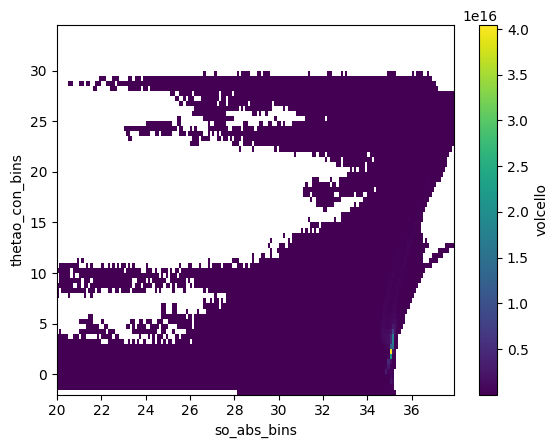

In [13]:
vol_thetao_so_atl.mean(dim='time_counter').plot()